Question-01

Radius (r): 42.42640687119285
Center (x, y): (234.0, 0.0)


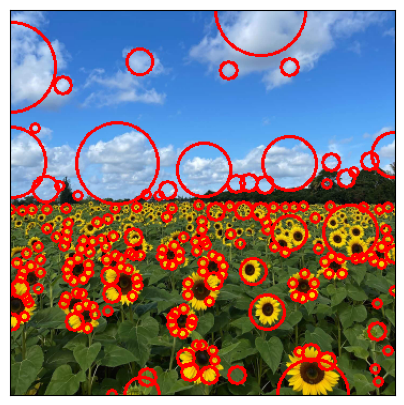

In [91]:
import cv2 as cv
import numpy as np
from skimage.feature import blob_log
from math import sqrt

# Load the image
im = cv.imread('the_berry_farms_sunflower_field.jpeg', cv.IMREAD_REDUCED_COLOR_4)

# Apply Gaussian blur to reduce noise
blurred = cv.GaussianBlur(im, (9, 9), 0.1)

# Convert the image to grayscale
gray = cv.cvtColor(blurred, cv.COLOR_BGR2GRAY)

# Define parameters for blob detection
min_sigma = 3
max_sigma = 30
threshold = .1

# Detect blobs using Laplacian of Gaussians
blobs = blob_log(gray, min_sigma=min_sigma, max_sigma=max_sigma, threshold=threshold)
blobs[:, 2] = blobs[:, 2] * sqrt(2)

max_radius_index = np.argmax(blobs[:, 2])
largest_circle_params = blobs[max_radius_index]
y, x, r = largest_circle_params
print(f"Radius (r): {r}")
print(f"Center (x, y): ({x}, {y})")

# Draw circles on the original color image
for blob in blobs:
    y, x, r = blob  # Blob format is (y, x, r)
    cv.circle(im, (int(x), int(y)), int(r), (0, 0, 255), 2)  # Draw circles in red
    
fig, ax = plt.subplots(figsize=(5, 5))
img = cv.cvtColor(im, cv.COLOR_BGR2RGB)
ax.imshow(img)
ax.set_xticks([])
ax.set_yticks([])

plt.show()

Question-02

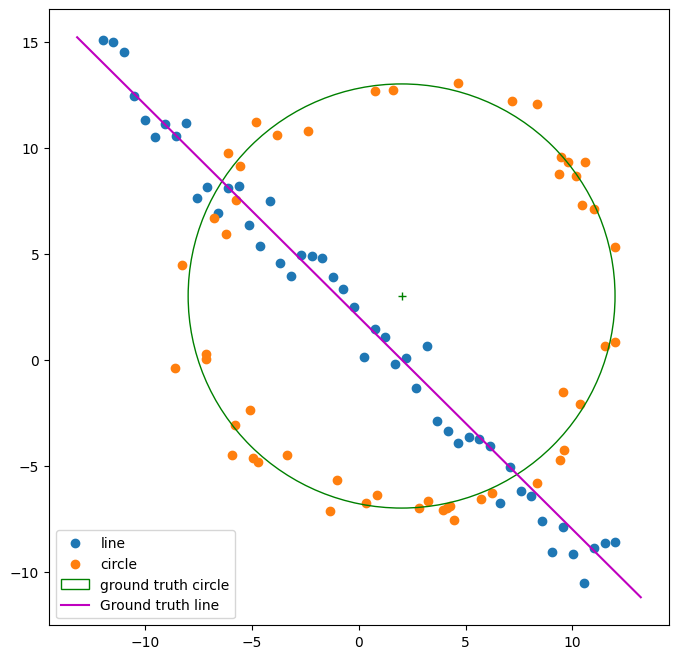

In [30]:
import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
import tikzplotlib
import circle_fit as cf
N = 100
half_n = N//2
r = 10
x0_gt,y0_gt=2,3 # Center
s = r/16
t = np.random.uniform(0 , 2*np.pi , half_n )
n = s*np.random.randn(half_n)
x,y=x0_gt +( r + n)*np.cos( t ),y0_gt + ( r + n)*np.sin( t )
X_circ = np.hstack((x.reshape ( half_n , 1 ) , y.reshape( half_n , 1 )))
s = 1.
m,b =-1,2
x =np.linspace(-12, 12 , half_n )
y = m*x + b + s*np.random.randn( half_n )
X_line = np.hstack((x.reshape(half_n, 1 ) , y.reshape( half_n ,1)))
X = np.vstack((X_circ,X_line))

fig,ax =plt.subplots(1,1, figsize=(8,8))
ax.scatter(X_line [:,0],X_line[:,1],label= "line")
ax.scatter( X_circ[:,0],X_circ[:,1],label= "circle")
circle_gt = plt.Circle((x0_gt , y0_gt ) , r , color= "g" , fill=False , label= "ground truth circle" )
ax.add_patch( circle_gt )
ax.plot((x0_gt ),(y0_gt),"+",color="g")
x_min,x_max = ax.get_xlim( )
x_ = np.array([ x_min , x_max ])
y_ = m*x_ + b
plt.plot( x_ , y_ , color= "m" , label=  "Ground truth line" )
plt.legend ( )


Best line model [0.73505824 0.67800397 1.93895763]


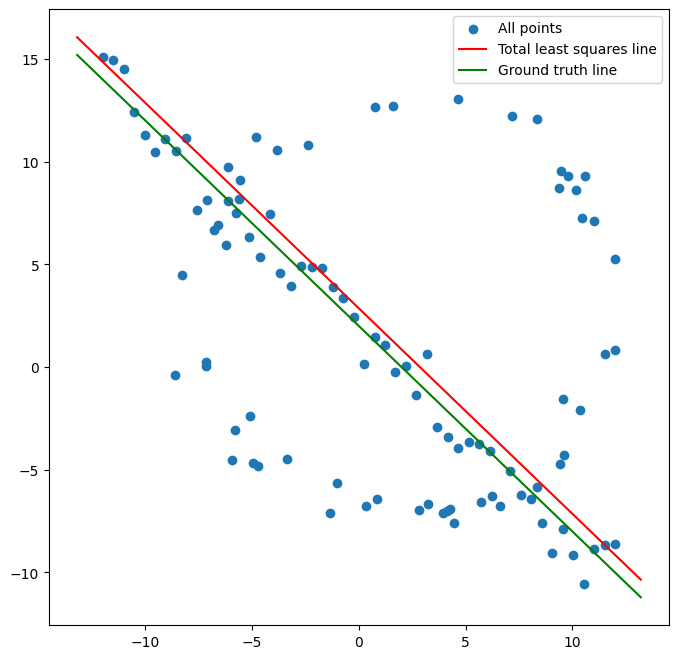

In [31]:
import math
N = X.shape[0]
X_ = X

m,c=-1,2

U = X_ - np.mean(X_, axis=0)

# Eigenvector of 𝑈^𝑇𝑈 associated with the smallest eigenvalue
_, _, Vt = np.linalg.svd(np.transpose(U)@U)
a, b = Vt[-1, 0], Vt[-1, 1]
d = a*np.mean(X_[:,0]) + b*np.mean(X_[:,1])
best_model_line = np.array([a, b, d])

print('Best line model', best_model_line)

fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.scatter(X[:,0],X[:,1], label='All points')
x_min, x_max = ax.get_xlim()
x_ = np.array([x_min, x_max])
y_ = (-best_model_line[1]*x_ + best_model_line[2])/best_model_line[1]
plt.plot(x_, y_, label='Total least squares line',c="r")
y_ = m*x_ + c
plt.plot(x_, y_, label='Ground truth line',c="g")
plt.legend()

Number of inliers: 51
Number of outliers: 49


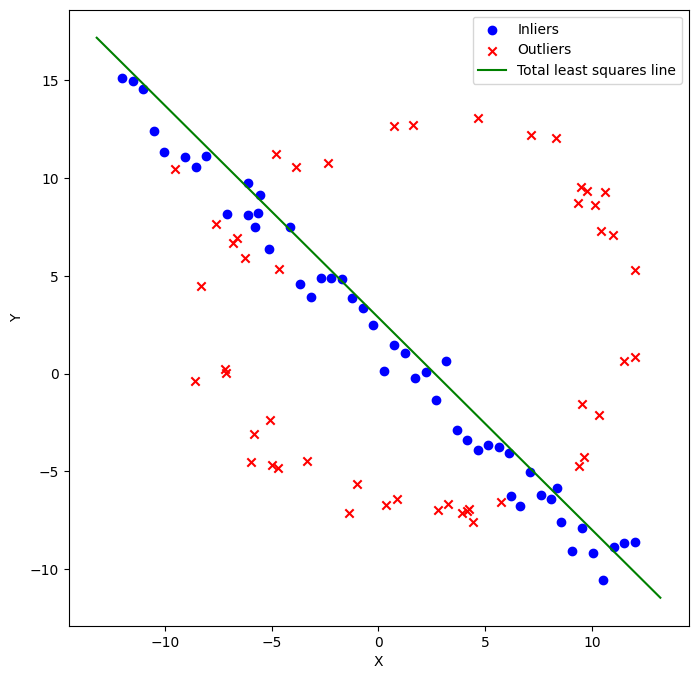

In [32]:
import numpy as np

# Define the line parameters (a, b, d) and distance threshold
a, b, d = best_model_line
distance_threshold = 1.7  # Adjust this threshold as needed

# Initialize arrays to store inliers and outliers
inliers = []
outliers = []

# Calculate and classify points as inliers or outliers
for x, y in X:
    distance = abs(a * x + b * y - d) 
    if distance <= distance_threshold:
        inliers.append([x, y])
    else:
        outliers.append([x, y])

# Convert inliers and outliers to NumPy arrays
inliers = np.array(inliers)
outliers = np.array(outliers)

# Print the number of inliers and outliers
print("Number of inliers:", len(inliers))
print("Number of outliers:", len(outliers))

# Optionally, plot the inliers, outliers, and line
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.scatter(inliers[:, 0], inliers[:, 1], label='Inliers', c='b', marker='o')
ax.scatter(outliers[:, 0], outliers[:, 1], label='Outliers', c='r', marker='x')
x_min, x_max = plt.xlim()
x_values = np.array([x_min, x_max])
y_values = (-a * x_values + d) / b
plt.plot(x_values, y_values, label='Total least squares line', c="g")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.show()


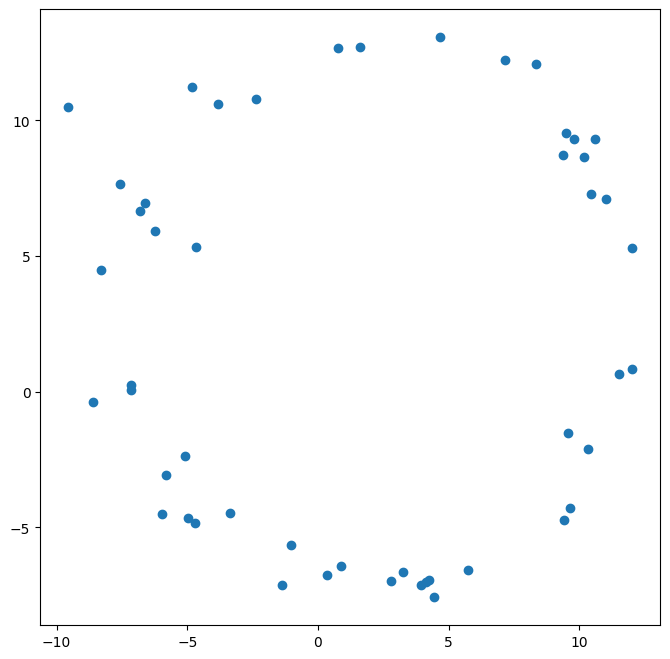

In [34]:
fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.scatter(outliers[:,0],outliers[:,1])

In [35]:
def circ_through_points(x1, x2, x3):
    denominator_1 = ( (x1[0] - x2[0]) * (x2[1] - x3[1]) - (x2[1] - x1[1]) * (x3[0] - x2[0]) )
    denominator_2 = ( (x1[0] - x2[0]) * (x2[1] - x3[1]) - (x2[1] - x1[1]) * (x3[0] - x2[0]) )

    if denominator_1 != 0 and denominator_2 != 0:
        a = 0.5 * ( (x2[1] - x3[1]) * (x1[0]**2 + x1[1]**2 - x2[0]**2 - x2[1]**2) + (x2[1] - x1[1]) * (x2[0]**2 + x2[1]**2 - x3[0]**2 - x3[1]**2) ) / denominator_1
        b = 0.5 * ( (x1[0] - x2[0]) * (x2[0]**2 + x2[1]**2 - x3[0]**2 - x3[1]**2) + (x3[0] - x2[0]) * (x1[0]**2 + x1[1]**2 - x2[0]**2 - x2[1]**2) ) / denominator_2
        c = -x3[0]**2 - x3[1]**2 + 2*a*x3[0] + 2*b*x3[1]

        r = np.sqrt(a**2 + b**2 - c)
    else:
        a,b,r = None, None, None

    return a, b, r

def get_inlier(a, b, r, X, d):
    count = 0
    best_fit_inliers = None

    for i in range(X.shape[0]):
        distance = abs( ( (X[i,0] - a)**2 + (X[i,1] - b)**2 ) ** 0.5 - r )

        if distance < d:
            count += 1

            if type(best_fit_inliers) == type(None):
                best_fit_inliers = np.array([X[i,:]])
            else:
                best_fit_inliers = np.concatenate((best_fit_inliers, X[i,:].reshape(1, -1)), axis=0)
    
    return count, best_fit_inliers    

In [41]:
def RANSAC(X): 
    S = 3
    d = 1.96 #gaussian threshold for selecting a 
    #correct outlier with p1 = 95% probability.
    e = 0.50
    p = 0.99
    N = int(np.ceil(np.log(1-p)/np.log(1-(1-e)**S)))

    best_fit_circle = None
    best_fit_x = None
    best_inlier_count = 0

    for _ in range(N):
        x = []

        for i in range(S):
            hold = X[np.random.randint(0, len(X)), :]
            
            if len(x) == 0:
                x.append(hold)
            elif np.array_equal(hold, x[-1]):                
                while np.array_equal(hold, x[-1]):
                    hold = X[np.random.randint(0, len(X)), :]
                
                x.append(hold)
            else:
                x.append(hold)
        
        a, b, r = circ_through_points(x[0], x[1], x[2])

        if a == None:
            continue

        count, inliers = get_inlier(a, b, r, X, d)

        if count > best_inlier_count:
            best_fit_circle = plt.Circle((a, b), r, color='b', fill=False, label="Best Sample")
            best_fit_x = x
            best_fit_inliers = inliers
            best_inlier_count = count
    
    if best_inlier_count < e:
        print("The RANSAC algorithm did not find a suitable model")
        return None, None, None, None

    xc,yc,r,_ = cf.least_squares_circle(best_fit_inliers)

    ransac_circle = plt.Circle((xc, yc), r, color='m', fill=False, label="RANSAC")
    
    return ransac_circle, best_fit_circle, best_fit_x, best_fit_inliers 

In [44]:
x=[]
hold = X[np.random.randint(0, len(X)), :]
x.append(hold)
hold = X[np.random.randint(0, len(X)), :]
np.array_equal(hold, x[-1])
hold

array([ 1.61357957, 12.70368252])

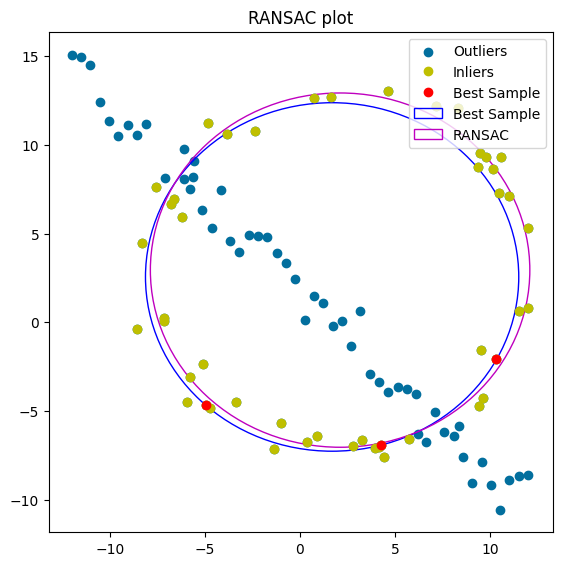

In [45]:
ransac_circle, best_fit_circle, x, inliers = RANSAC(outliers)

if ransac_circle != None:
    fig, ax = plt.subplots(1, 1, figsize=(6.5,6.5))
    ax.scatter(X_circ[:,0], X_circ[:,1], color="#026f9e")
    ax.scatter(X_line[:,0], X_line[:,1], color="#026f9e", label="Outliers")

    if type(inliers) != type(None):
        for point in inliers:
            if np.array_equal(point, inliers[-1]):
                ax.plot(point[0], point[1], 'yo', label="Inliers")
            else:
                ax.plot(point[0], point[1], 'yo')


    for point in x:
        if np.array_equal(point, x[-1]):
            ax.plot(point[0], point[1], 'ro', label="Best Sample")
        else:
            ax.plot(point[0], point[1], 'ro')

    ax.add_patch(best_fit_circle)
    ax.add_patch(ransac_circle)
    ax.set_title("RANSAC plot")
    ax.legend(loc="upper right")

Question-03

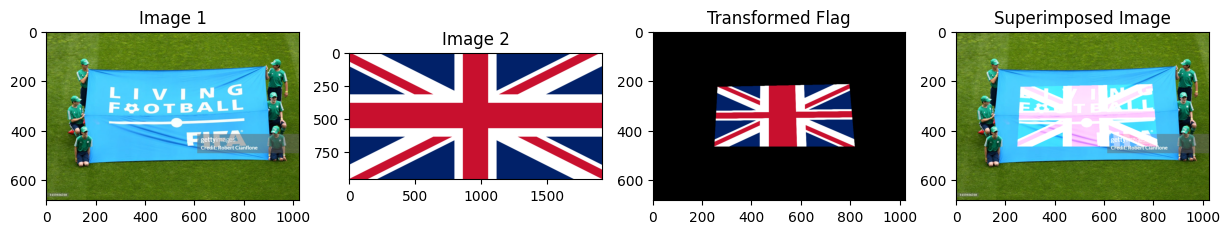

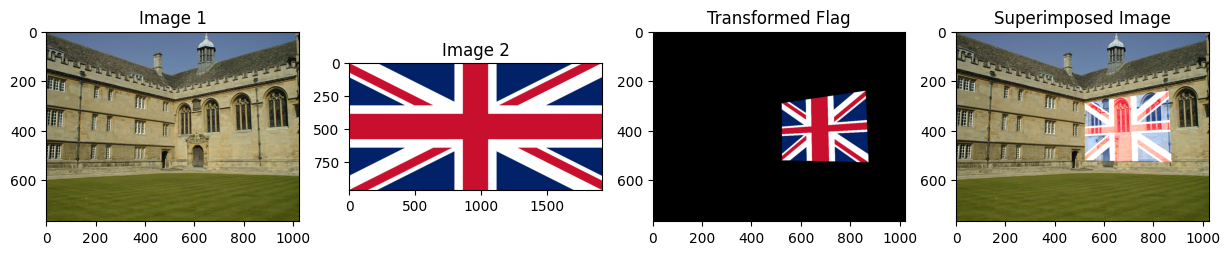

In [28]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

corners = []
def mouse_click(event, x, y, flags, params):
    if event == cv.EVENT_LBUTTONDOWN:
        corners.append([x,y])

ims = ["flag2.jpg","001.jpg"]
for i in range(2):
    im = cv.imread(ims[i])
    cv.imshow("Wadham College",im)
    corners = []
    cv.setMouseCallback("Wadham College", mouse_click), cv.waitKey(0), cv.destroyAllWindows()

    h, w = np.shape(im)[0], np.shape(im)[1]
    zero_matrix = np.array([[0], [0], [0]])

    x1, y1, x2, y2, x3, y3, x4, y4 = corners[0][0], corners[0][1], corners[1][0], corners[1][1], corners[2][0], corners[2][1], corners[3][0], corners[3][1]

    flag_im = cv.imread("Flag_of_the_United_Kingdom.png")
    fh, fw , ch= flag_im.shape
    f1, f2, f3, f4 = np.array([[0, 0, 1]]), np.array([[fw-1, 0, 1]]), np.array([[fw-1, fh-1, 1]]), np.array([[0, fh-1, 1]])

    matrix_A = np.concatenate((np.concatenate((zero_matrix.T,f1, -y1*f1), axis = 1), np.concatenate((f1, zero_matrix.T, -x1*f1), axis = 1),
                                np.concatenate((zero_matrix.T,f2, -y2*f2), axis = 1), np.concatenate((f2, zero_matrix.T, -x2*f2), axis = 1),
                                np.concatenate((zero_matrix.T,f3, -y3*f3), axis = 1), np.concatenate((f3, zero_matrix.T, -x3*f3), axis = 1),
                                np.concatenate((zero_matrix.T,f4, -y4*f4), axis = 1), np.concatenate((f4, zero_matrix.T, -x4*f4), axis = 1)), axis = 0, dtype=np.float64)

    W, v = np.linalg.eig(((matrix_A.T)@matrix_A))
    temph= v[:,np.argmin(W)]
    H = temph.reshape((3,3))
    transformed_flag = cv.warpPerspective(flag_im, H, (w, h))
    final = cv.add(transformed_flag, im)
    fig, ax = plt.subplots(1,4,figsize=(15,15))
    ax[0].imshow(cv.cvtColor(im,cv.COLOR_BGR2RGB)), ax[0].set_title("Image 1")
    ax[1].imshow(cv.cvtColor(flag_im,cv.COLOR_BGR2RGB)), ax[1].set_title("Image 2")
    ax[2].imshow(cv.cvtColor(transformed_flag,cv.COLOR_BGR2RGB)), ax[2].set_title("Transformed Flag")
    ax[3].imshow(cv.cvtColor(final,cv.COLOR_BGR2RGB)), ax[3].set_title("Superimposed Image")
    plt.show()

Question-04

(a) Compute and match SIFT features between the two images.

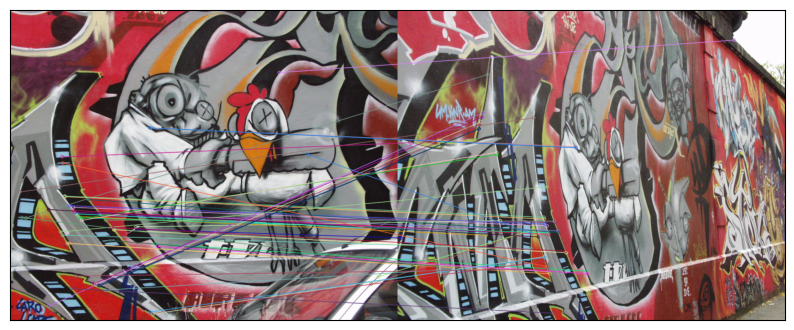

In [29]:
from scipy.optimize import minimize
from scipy import linalg
import matplotlib.pyplot as plt


img1 = cv.imread('img1.ppm')
img5 = cv.imread('img5.ppm')
assert img1 is not None
assert img5 is not None

img1_gray = cv.cvtColor(img1, cv.COLOR_BGR2GRAY)
img5_gray = cv.cvtColor(img5, cv.COLOR_BGR2GRAY)
img1 = cv.cvtColor(img1, cv.COLOR_BGR2RGB)
img5 = cv.cvtColor(img5, cv.COLOR_BGR2RGB) 

sift = cv.SIFT_create(nOctaveLayers = 3, contrastThreshold = 0.1, edgeThreshold = 25, sigma = 1)
bf = cv.BFMatcher(cv.NORM_L2SQR, crossCheck=True)

key1, des1 = sift.detectAndCompute(img1_gray, None)
key5, des5 = sift.detectAndCompute(img5_gray, None)

matches = bf.match(des1, des5)
matches = sorted(matches, key=lambda x:x.distance)

out_img = cv.drawMatches(img1, key1, img5, key5, matches[:50], img5, flags=2)

fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(out_img)
ax.set_xticks([])
ax.set_yticks([])

plt.show()

(b) Compute the homography using your own code within RANSAC and compare with the homography given in the dataset

In [60]:
import cv2 as cv
from scipy.optimize import minimize
from scipy import linalg
import matplotlib.pyplot as plt

sift = cv.SIFT_create()

kp1, desc1 = sift.detectAndCompute(img1, None)
kp2, desc2 = sift.detectAndCompute(img5, None)

bf = cv.BFMatcher()
matches = bf.knnMatch(desc1, desc2, k=2)
good, pts1, pts2 = [], [], []

for m, n in matches:
    if m.distance < 0.75*n.distance:
        good.append([m])
        pts1.append(kp1[m.queryIdx].pt)
        pts2.append(kp2[m.trainIdx].pt)

good, pts1, pts2 = np.array(good), np.array(pts1), np.array(pts2)
matched_img = cv.drawMatchesKnn(img1, kp1, img5, kp2, good[:50], None, flags=2)

def homography(pts1, pts2):
    mean1, mean2 = np.mean(pts1, axis=0), np.mean(pts2, axis=0)
    s1, s2 = len(pts1)*np.sqrt(2)/np.sum(np.sqrt(np.sum((pts1-mean1)**2, axis=1))), len(pts1)*np.sqrt(2)/np.sum(np.sqrt(np.sum((pts2-mean2)**2, axis=1)))
    tx1, ty1, tx2, ty2 = -s1*mean1[0], -s1*mean1[1], -s2*mean2[0], -s2*mean2[1]
    T1, T2 = np.array(((s1, 0, tx1), (0, s1, ty1), (0, 0, 1))), np.array(((s2, 0, tx2), (0, s2, ty2), (0, 0, 1)))
    A = []

    for i in range(len(pts1)):
        X11, X21 = T1 @ np.concatenate((pts1[i], [1])).reshape(3, 1), T2 @ np.concatenate((pts2[i], [1])).reshape(3, 1)
        A.append((-X11[0][0], -X11[1][0], -1, 0, 0, 0, X21[0][0]*X11[0][0], X21[0][0]*X11[1][0], X21[0][0]))
        A.append((0, 0, 0, -X11[0][0], -X11[1][0], -1, X21[1][0]*X11[0][0], X21[1][0]*X11[1][0], X21[1][0]))
    
    A = np.array(A)
    U, S, V = np.linalg.svd(A, full_matrices=True)
    h = np.reshape(V[-1], (3, 3))
    H = linalg.inv(T2) @ h @ T1
    H = (1 / H.item(8)) * H
    return H
        
def dist(P1, P2, H):
    p1 = np.array([P1[0], P1[1], 1])
    p2 = np.array([P2[0], P2[1], 1])

    p2_estimate = np.dot(H, p1.T)
    p2_estimate = (1 / p2_estimate[2]) * p2_estimate
    return np.linalg.norm(p2.T - p2_estimate)

def RANSAC_homography(points1, points2):
    inlier_count, selected_inliers = 0, None
    points = np.hstack((points1, points2))
    num_iterations = int(np.log(1 - 0.95)/np.log(1 - (1 - 0.5)**4))
    
    for _ in range(num_iterations):
        np.random.shuffle(points)
        pts1, pts1_rem, pts2, pts2_rem = points[:4, :2],  points[4:, :2], points[:4, 2:], points[4:, 2:]
        H = homography(pts1, pts2)
        inliers = [(pts1_rem[i], pts2_rem[i]) for i in range(len(pts1_rem)) if dist(pts1_rem[i], pts2_rem[i], H) < 100]
        if len(inliers) > inlier_count:
            inlier_count = len(inliers)
            selected_inliers = np.array(inliers)
    
    H = homography(selected_inliers[:, 0], selected_inliers[:, 1])
    return H

H = RANSAC_homography(pts1, pts2)
print(H)



[[-2.97283674e-01 -4.17396920e-01  3.57204005e+02]
 [-3.57169400e-01  1.69792767e-01  2.10563639e+02]
 [-1.15364931e-03 -6.40276575e-04  1.00000000e+00]]


(c) Stitch img1.ppm onto img5.ppm.

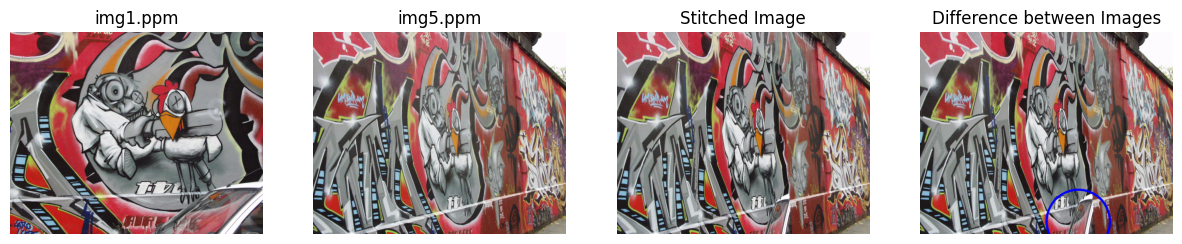

In [92]:
file = open(r"H1to5p", "r")
H = []

for _ in range(3):
    H.append(tuple(map(float, file.readline().strip().split())))

H = np.array(H)
img_p = cv.warpPerspective(img1, H, (img5.shape[1], img5.shape[0]))
ret, threshold = cv.threshold(img_p, 10, 1, cv.THRESH_BINARY_INV)
img2_thresholded = np.multiply(threshold, img5)
img_blended = cv.addWeighted(img2_thresholded, 1, img_p, 1, 0)

fig, ax = plt.subplots(1, 4, figsize=(15, 12))
ax[0].imshow(img1)
ax[0].set_title("img1.ppm")
ax[0].axis("off")
ax[1].imshow(img5)
ax[1].set_title("img5.ppm")
ax[1].axis("off")
ax[2].imshow(img_blended)
ax[2].set_title("Stitched Image")
ax[2].axis("off")

img_blended = cv.circle(img_blended, (500, 600), 100, (0, 0, 255), 5)

ax[3].imshow(img_blended)
ax[3].set_title("Difference between Images")
ax[3].axis("off")


plt.show()